# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [33]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# opencv library
import cv2
# computational library
import numpy as np
# pandas dataframe
import pandas as pd
#random
import random
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR

# generic Trainer class imports
from trainer import Trainer, hooks
from trainer.utils import (  # pylint: disable=unused-import
    setup_system,
    patch_configs,
    download_git_folder,
    get_image_dataset_parameters,
    draw_semantic_segmentation_batch,
    draw_semantic_segmentation_samples,
    init_semantic_segmentation_dataset,
)
from trainer.base_metric import BaseMetric
from trainer.configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from trainer.matplotlib_visualizer import MatplotlibVisualizer
import tools

tools.utils.seed_system(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# dataset class implementation
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder
            
            Names of images in the images_folder and masks_folder should match the same sample.

    """
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes,
        transforms=None,
        class_names=None,
        dataset_url=None,
        dataset_folder=None
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        # check whether dataset loading parameters exist
        if not os.path.isdir(data_path) and dataset_url is not None and dataset_folder is not None:
            # download CamVid dataset to the predefined directory
            download_git_folder(dataset_url, dataset_folder, data_path)
        # get the map of image-mask pairs
        self.dataset = init_semantic_segmentation_dataset(data_path, images_folder, masks_folder)

    def get_num_classes(self):
        """Get number of classes in the dataset"""
        return self.num_classes

    def get_class_name(self, idx):
        """
            Get a specific class name

            Arguments:
                idx (int): index of specific class.

            Returns:
                If class_names are available and idx < number of classes,
                returns a specific class name, else returns an empty string.
        """
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
        sample = {
            "image": cv2.imread(self.dataset[idx]["image"])[..., ::-1],
            "mask": cv2.imread(self.dataset[idx]["mask"], 0)
        }
        # apply transforms to a sample
        if self.transforms is not None:
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
        return sample

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

<IPython.core.display.Javascript object>


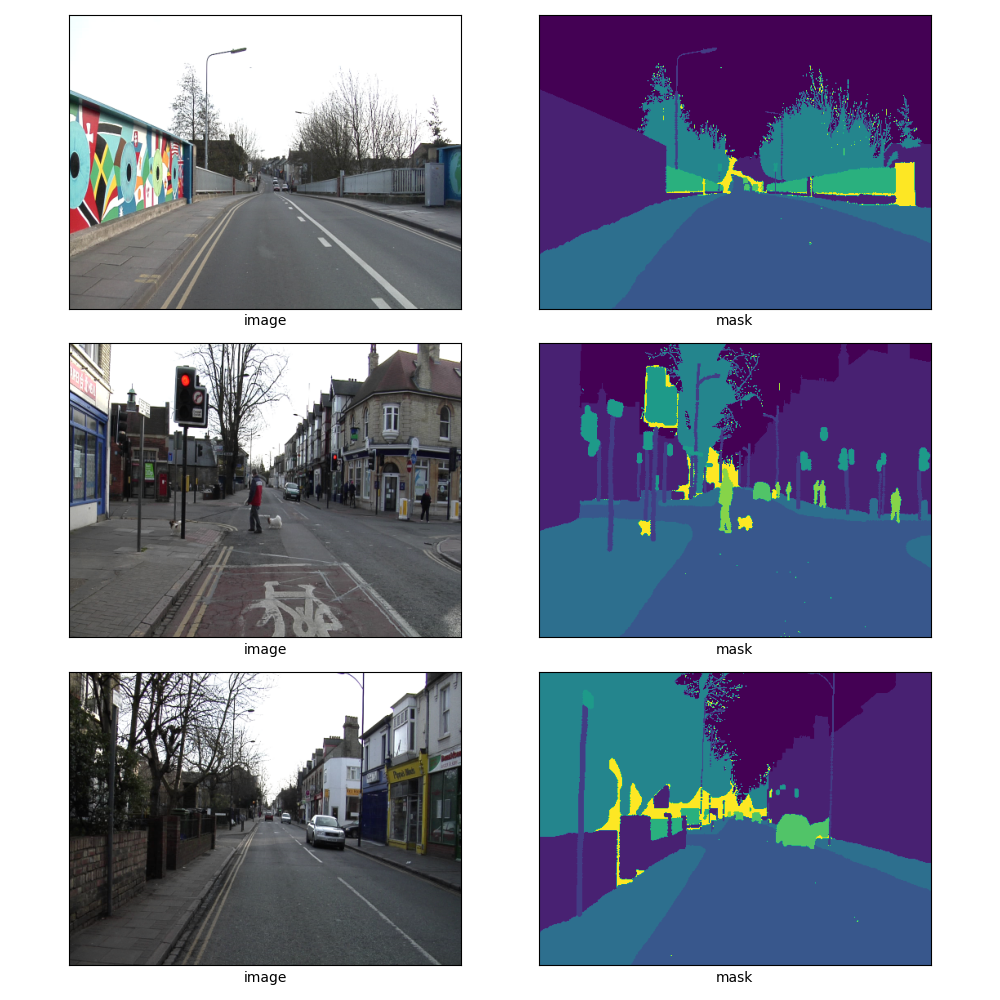

In [36]:
# create test dataset
test_dataset = SemSegDataset(**get_image_dataset_parameters(
        data_path="data",
        dataset_type="test"
    ))
draw_semantic_segmentation_samples(test_dataset, n_samples=3)

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [53]:
# create confusion matrix class
class ConfusionMatrix(BaseMetric):
    """
        Implementation of Confusion Matrix.

        Arguments:
            num_classes (int): number of evaluated classes.
            normalized (bool): if normalized is True then confusion matrix will be normalized.
    """
    def __init__(self, num_classes, normalized=False):
        # init confusion matrix class fields
        self.num_classes = num_classes
        self.normalized = normalized
        self.conf = np.ndarray((num_classes, num_classes), np.int32)
        self.reset()

    def reset(self):
        """
            Reset of the Confusion Matrix.
        """
        self.conf.fill(0)

    def update_value(self, pred, target):
        """
            Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if torch.is_tensor(pred):
            # convert the prediction tensor to numpy array
            pred = pred.detach().cpu().numpy()
        if torch.is_tensor(target):
            # convert the target tensor to numpy array
            target = target.detach().cpu().numpy()

        # get rid of invalid indices
        valid_indices = np.where((target >= 0) & (target < self.num_classes))
        pred = pred[valid_indices]
        target = target[valid_indices]

        # calculate confusion matrix value for new predictions
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T
        conf, _ = np.histogramdd(
            replace_indices,
            bins=(self.num_classes, self.num_classes),
            range=[(0, self.num_classes), (0, self.num_classes)]
        )
        # update confusion matrix value
        self.conf += conf.astype(np.int32)

    def get_metric_value(self):
        """
            Return the Confusion Matrix.

            Returns:
                numpy.ndarray(num_classes, num_classes): confusion matrix.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            # get normalized confusion matrix
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        return self.conf

In [50]:
class ConfusionMatrixBasedMetric:
    """ Implementation of base class for Confusion Matrix based metrics.

    Arguments:
        num_classes (int): number of evaluated classes.
        reduced_probs (bool): if True then argmax was applied to input predicts.
        normalized (bool): if normalized is True then confusion matrix will be normalized.
        ignore_indices (int or iterable): list of ignored classes index.
    """
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        """ Reset of the Confusion Matrix
        """
        self.conf_matrix.reset()

    def add(self, pred, target):
        """ Add sample to the Confusion Matrix.

        Arguments:
            pred (torch.Tensor() or numpy.ndarray): predicted mask.
            target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.add(pred, target)

In [66]:
# DiceCoefficient class inherited from ConfusionMatrixBasedMetric : DiceCoefficient
class DiceCoefficient(ConfusionMatrixBasedMetric):
    """ Correct implementation of the Dice metric.

    Arguments:
        num_classes (int): number of evaluated classes.
        reduced_probs (bool): if True then argmax was applied to input predicts.
        normalized (bool): if normalized is True then confusion matrix will be normalized.
        ignore_indices (int or iterable): list of ignored classes indices.
    """

    # the core coefficient computation method
    def value(self):
        """ Return of the mean Dice and Dice per class.

        Returns:
            mdice (float32): mean dice.
            dice (list): list of dice coefficients per class.
        """
        # get confusion matrix value
        conf_matrix = self.conf_matrix.value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values for Dice calculation using confusion matrix
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate dice by its formula
            dice = 2 * true_positive / (2 * true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            dice_valid_cls = np.delete(dice, self.ignore_indices)
            # get mean class dice coefficient ignoring NaN values
            mdice = np.nanmean(dice_valid_cls)
        else:
            # get mean class dice coefficient ignoring NaN values
            mdice = np.nanmean(dice)

        return mdice, dice

In [67]:
# create intersection over union class
class IntersectionOverUnion(BaseMetric):
    """
        Implementation of the Intersection over Union metric.

        Arguments:
            num_classes (int): number of evaluated classes.
            reduced_probs (bool): if True, then argmax was applied to the input predictions.
            normalized (bool): if normalized is True, then confusion matrix will be normalized.
            ignore_indices (int or iterable): list of ignored classes indices.
    """
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        # created a normalized confusion matrix with num_classes
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        # check whether ignored classes exist
        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        """
            Reset the Confusion Matrix
        """
        self.conf_matrix.reset()

    def update_value(self, pred, target):
        """ Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.update_value(pred, target)

    def get_metric_value(self):
        """
            Return mIOU and IOU per class.

            Returns:
                miou (float32): mean intersection over union.
                iou (list): list of intersection over union per class.
        """
        # get confusion matrix value
        conf_matrix = self.conf_matrix.get_metric_value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate iou by its formula
            iou = true_positive / (true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            iou_valid_cls = np.delete(iou, self.ignore_indices)
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou_valid_cls)
        else:
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou)
        return {"mean_iou": miou, "iou": iou}

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [68]:
# create resnet encoder module
class ResNetEncoder(nn.Module):
    """ ResNet encoder.

        Arguments:
            resnet_type (string): type of resnet (all resnet network which exist in torchvision).
            pretrained (bool): if pretrained == True, ImageNet weights will load.
    """
    def __init__(self, resnet_type="resnet18", pretrained=True):
        super().__init__()
        # get PyTorch ResNet18 as feature extractor
        self.module = getattr(models, resnet_type)(pretrained=pretrained)

    # get output
    def get_channels_out(self):
        """
            Get num channels of output feature pyramid.

            Returns:
                List of num channels for each feature pyramid layer.
        """
        channels_out = []
        for layer in [getattr(self.module, "layer{}".format(i)) for i in range(1, 5)]:
            channels_out.append(self._get_block_size(layer))
        return channels_out[::-1]

    # define forward pass
    def forward(self, x):
        # init PyTorch ResNet18 layers
        # output number of channels = 64
        x = self.module.conv1(x)
        # output number of channels = 64
        x = self.module.bn1(x)
        # output number of channels = 64
        x = self.module.relu(x)
        # output number of channels = 64
        x = self.module.maxpool(x)

        # output number of channels = 64
        l1_output = self.module.layer1(x)
        # output number of channels = 128
        l2_output = self.module.layer2(l1_output)
        # output number of channels = 256
        l3_output = self.module.layer3(l2_output)
        # output number of channels = 512
        l4_output = self.module.layer4(l3_output)

        return l1_output, l2_output, l3_output, l4_output

    # get size of a module
    @staticmethod
    def _get_block_size(module):
        return list(module[-1].modules())[-2].weight.size()[0]

In [69]:
# create connection layers between encoder and decoder blocks
class LateralConnection(nn.Module):
    """
        Lateral connection.

        Arguments:
            channels_in (int): number of input channels.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # create output number of channels from input
        self.proj = nn.Conv2d(channels_in, channels_out, kernel_size=1)

    # define forward pass
    def forward(self, prev, cur):
        # interpolating the previous feature map
        up = F.interpolate(prev, cur.size()[-2:], mode="nearest")
        # project consistent number of channels
        proj = self.proj(cur)
        # summarize feature maps into one
        return proj + up


# create decoder module
class FPNDecoder(nn.Module):
    """
        Feature Pyramid Decoder.
            Aggregate all feature pyramid layers using lateral connections.

        Arguments:
            channels_in (list): list of input channels for each feature pyramid layer.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out=256):
        super().__init__()
        # init decoder as a list of modules
        self.module = nn.ModuleList()
        # create lateral connections between encoder and decoder blocks
        # for the last encoder block there is no need for upsampling
        self.module.append(nn.Conv2d(channels_in[0], channels_out, kernel_size=1))
        for i in range(1, len(channels_in)):
            self.module.append(LateralConnection(channels_in[i], channels_out))

    # define forward pass
    def forward(self, x):
        # append outputs after each laternl layer
        output = [self.module[0](x[0])]
        for i in range(1, len(x)):
            output.append(self.module[i](output[i - 1], x[i]))
        return output

In [70]:
# create semantic segmentation model
class SemanticSegmentation(nn.Module):
    """
        Semantic Segmentation model using Feature Pyramid Network.

        Arguments:
            num_classes (int): number of classes.
            encoder_type (class): type of encoder network.
            channels_out (int): number of channels of the output features.
            final_upsample (bool): if final_upsample is True then final prediction will be upsampled to the 
                                   original resolution.
    """
    def __init__(self, num_classes, encoder_type=ResNetEncoder, channels_out=128, final_upsample=False):
        super().__init__()
        # init fields
        self.final_upsample = final_upsample
        self.encoder = encoder_type()
        # create decoder
        self.decoder = FPNDecoder(self.encoder.get_channels_out(), channels_out=channels_out)
        # create classifier with num_classes as output
        self.classifier = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
            nn.Conv2d(channels_out, num_classes, kernel_size=1),
        )

    # define forward pass as a sequence of forward passes between all modules
    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder[::-1])
        classifier = self.classifier(decoder[-1])

        # upsample to the input image size if needed
        if self.final_upsample:
            classifier = F.interpolate(classifier, x.size()[-2:], mode="bilinear", align_corners=False)

        # output number of channels is equal to number of dataset classes
        return classifier

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


In [71]:
# define experiment class
class Experiment:
    def __init__(
        self,
        # init configs
        system_config: SystemConfig = SystemConfig(),
        dataset_config: DatasetConfig = DatasetConfig(),
        dataloader_config: DataloaderConfig = DataloaderConfig(),
        optimizer_config: OptimizerConfig = OptimizerConfig(),
    ):
        # apply system settings
        self.system_config = system_config
        setup_system(system_config)
        # define train dataloader
        self.loader_train = DataLoader(
            # define our dataset
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="train",
                    # define augmentations
                    transforms=Compose([
                        HorizontalFlip(),
                        ShiftScaleRotate(
                            shift_limit=0.0625,
                            scale_limit=0.50,
                            rotate_limit=45,
                            border_mode=cv2.BORDER_CONSTANT,
                            value=0,
                            mask_value=11,
                            p=.75
                        ),
                        HueSaturationValue(),
                        RandomCrop(height=352, width=480),
                        Normalize(),
                        ToTensorV2()
                    ])
                )
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define test dataloader
        self.loader_test = DataLoader(
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="test",
                    transforms=Compose([Normalize(), ToTensorV2()])
                )
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define model
        self.model = SemanticSegmentation(
            num_classes=self.loader_test.dataset.get_num_classes(), final_upsample=True
        )
        # define loss function as cross-entropy loss
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.loader_test.dataset.get_num_classes())
        # define metrics function as intersection over union
        self.metric_fn = IntersectionOverUnion(
            num_classes=self.loader_test.dataset.get_num_classes(), reduced_probs=False
        )
        # define optimizer and its params
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay
        )
        # define learning rate scheduler
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        # define visualizer
        self.visualizer = MatplotlibVisualizer()

    # run training
    def run(self, trainer_config: TrainerConfig) -> dict:
        # apply system settings
        setup_system(self.system_config)
        # move training to the chosen device
        device = torch.device(trainer_config.device)
        # send data to chosen device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        # define trainer
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("mask"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mean_iou"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        # define hook to run after each epoch
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_semseg)
        # run the training
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

<IPython.core.display.Javascript object>


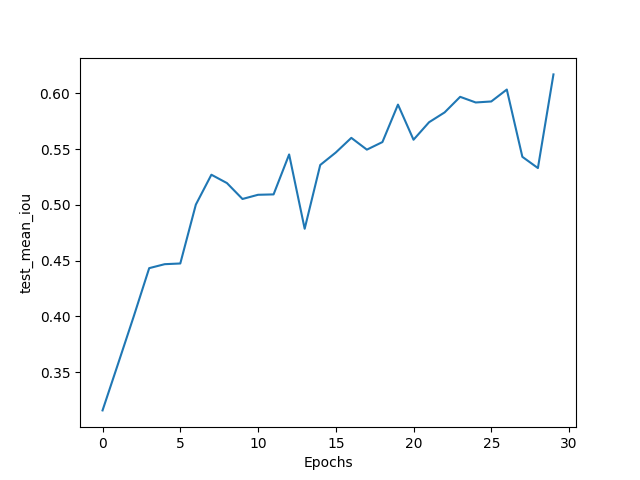

<IPython.core.display.Javascript object>


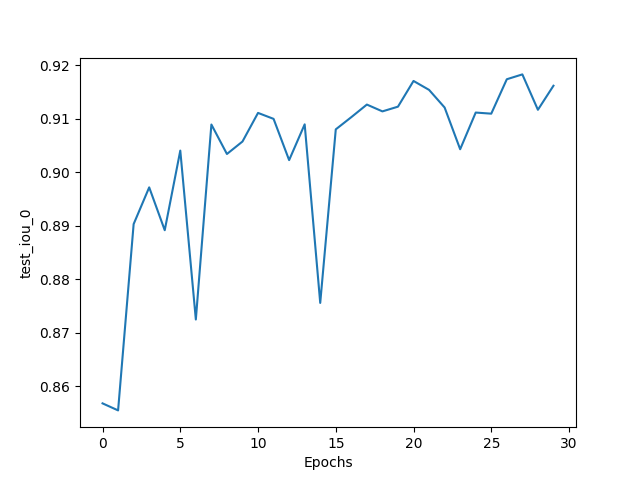

<IPython.core.display.Javascript object>


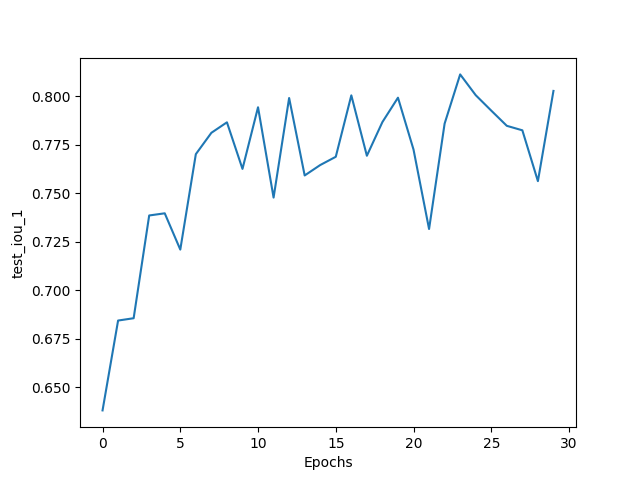

<IPython.core.display.Javascript object>


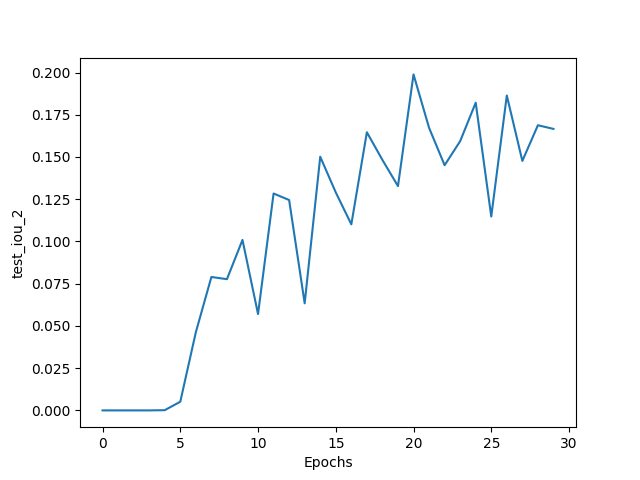

<IPython.core.display.Javascript object>


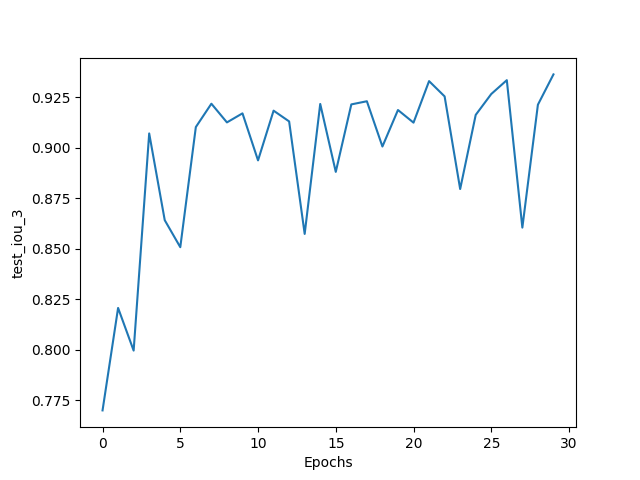

<IPython.core.display.Javascript object>


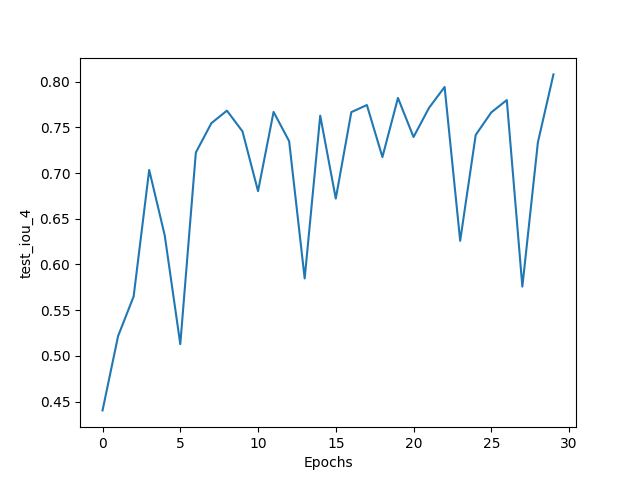

<IPython.core.display.Javascript object>


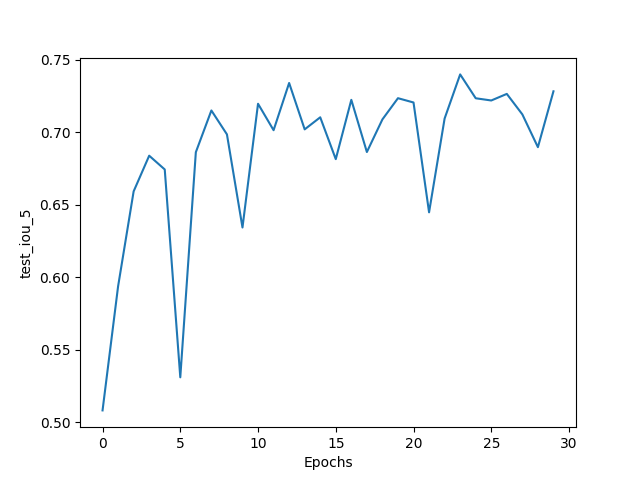

<IPython.core.display.Javascript object>


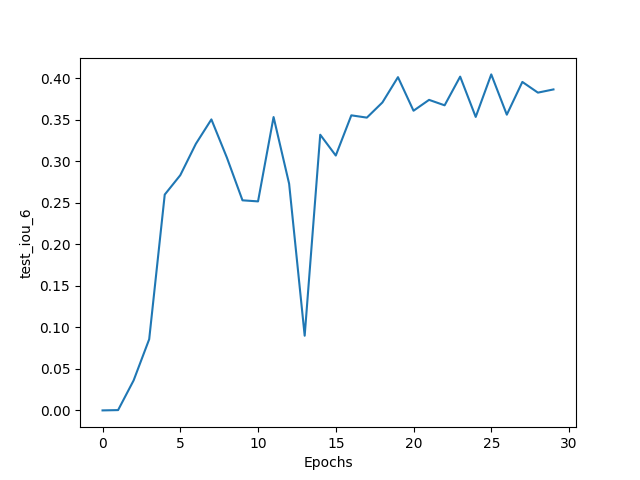

<IPython.core.display.Javascript object>


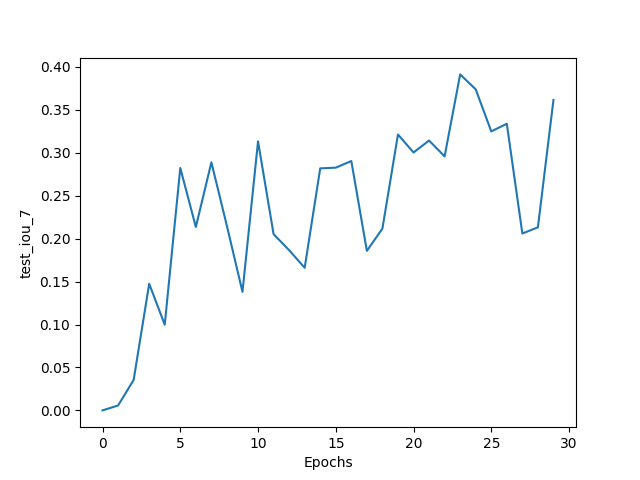

<IPython.core.display.Javascript object>


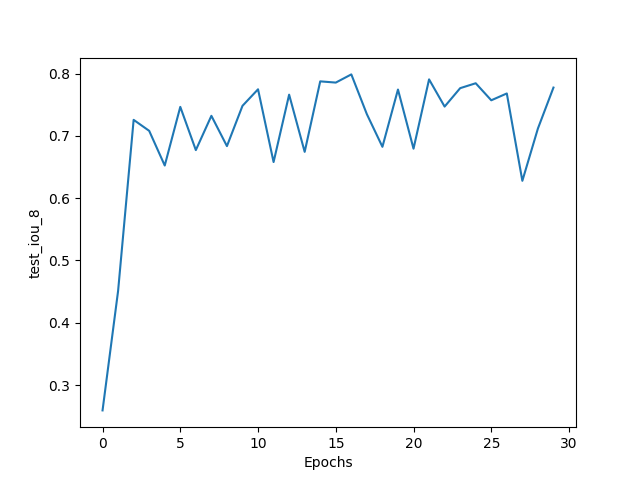

<IPython.core.display.Javascript object>


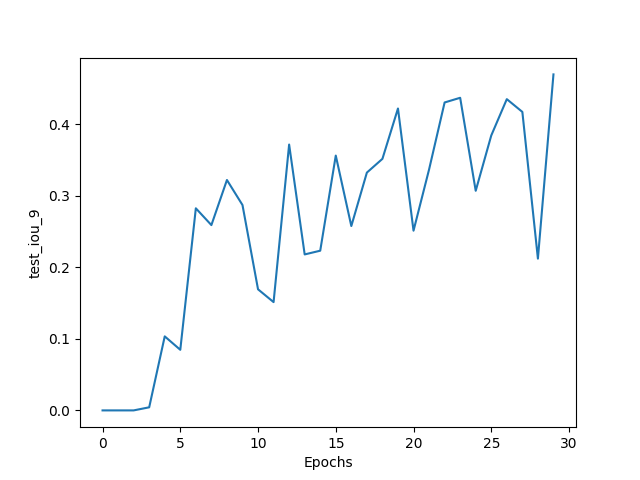

<IPython.core.display.Javascript object>


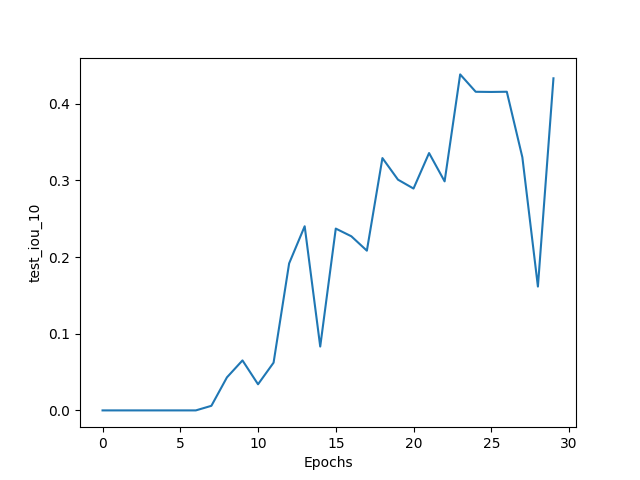

<IPython.core.display.Javascript object>


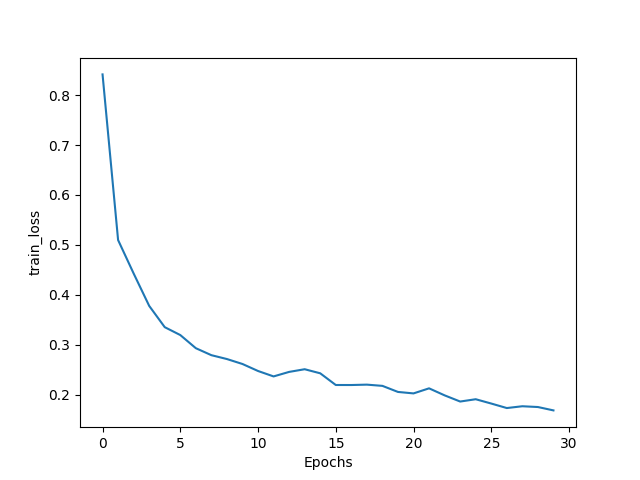

<IPython.core.display.Javascript object>


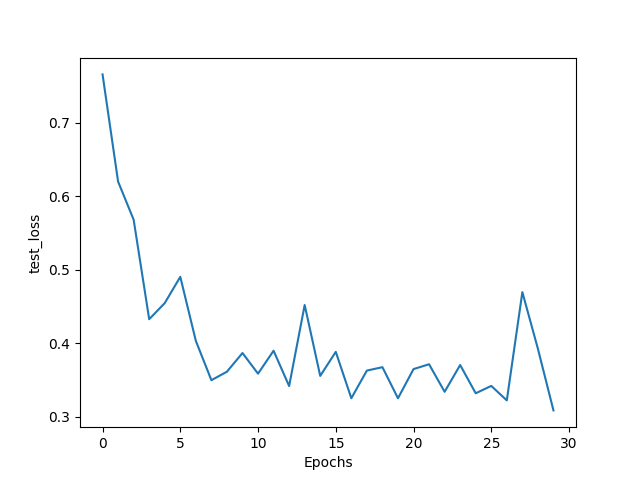

<IPython.core.display.Javascript object>


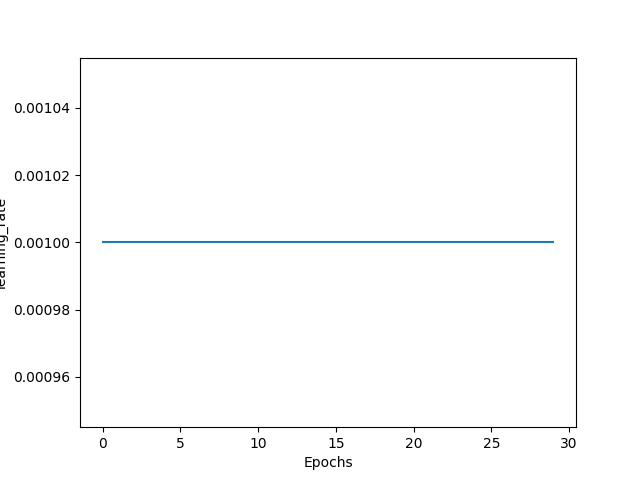

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [72]:
# run the experiment
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=30, batch_size_to_set=16)

optimizer_config = OptimizerConfig(learning_rate=1e-3, lr_step_milestones =[], weight_decay=4e-5)
experiment = Experiment(dataloader_config=dataloader_config, optimizer_config=optimizer_config)
metrics = experiment.run(trainer_config)

<IPython.core.display.Javascript object>


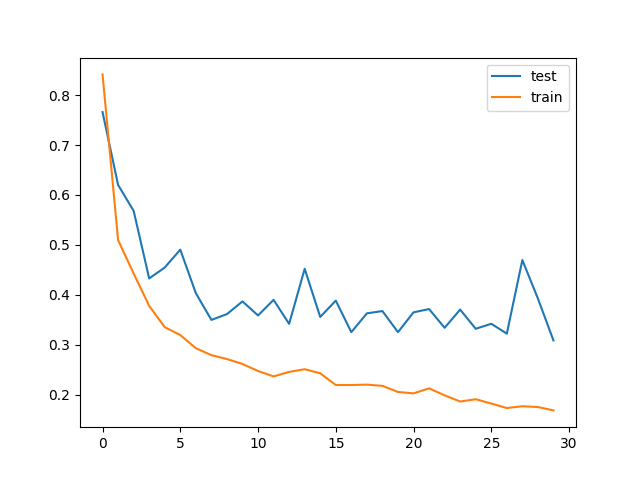

<IPython.core.display.Javascript object>


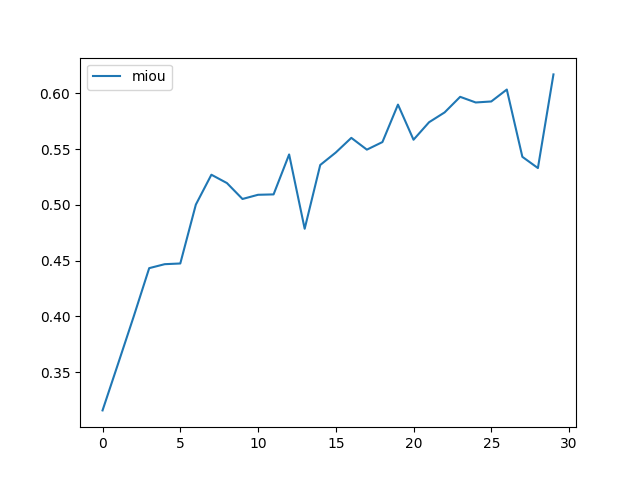

In [73]:
# create new figure
plt.figure()
# plot test and train loss
plt.plot(metrics["test_loss"], label="test")
plt.plot(metrics["train_loss"], label="train")
plt.legend()
plt.show()

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['mean_iou'] for metric in metrics["test_metric"]], label="miou")
plt.legend()
plt.show()

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



<IPython.core.display.Javascript object>


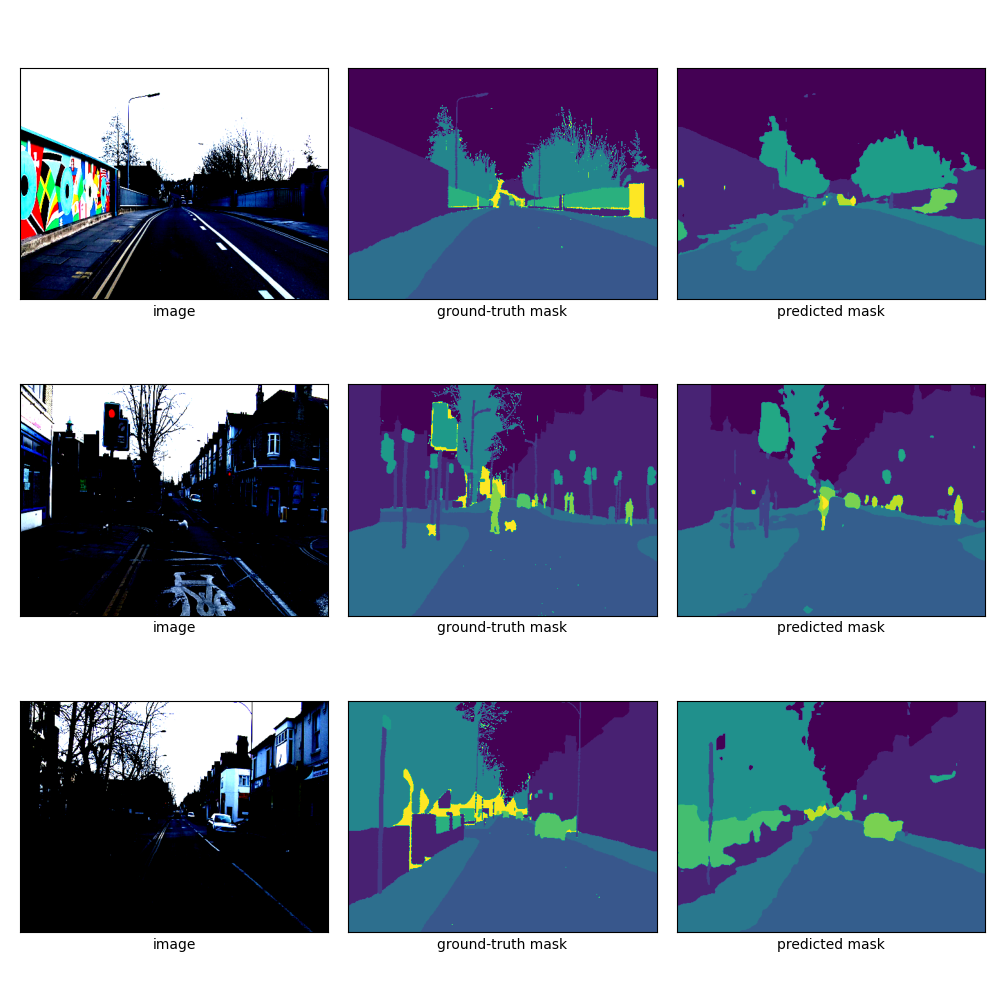

In [74]:
# get test samples
sample = next(iter(experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)

# get predictions
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [ ]:
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)

# get predictions
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)

In [97]:
class Submission(object):
    root_dir = "./submissions"
    csv_fields = ("ImageID", "EncodedPixels")
    
    @classmethod
    def __encode(cls, binary_array):
        from itertools import accumulate, groupby

        # compute the length of "0" and "1" pixel runs
        lengths = []
        for i, (value, elements) in enumerate(groupby(binary_array.ravel())):
            if i == 0 and value == 1:
                lengths.append(0)
            lengths.append(len(list(elements)))

        # compute the offsets of the pixel runs
        offsets = list(accumulate([0] + lengths))[:-1]

        # discard the offsets and lengths that correspond to the "0" pixels
        lengths = lengths[1::2]
        offsets = offsets[1::2]

        # interleave the offsets and lengths and convert to a string
        encoding = [val for pair in zip(offsets, lengths) for val in pair]
        return ' '.join(map(str, encoding))
    
    @classmethod
    def create(cls, fname, iterable):
        import csv
        os.makedirs(Submission.root_dir, exist_ok=True)
        path = os.path.join(Submission.root_dir, fname)
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(Submission.csv_fields)
            pbar_test_iter = tqdm(iterable, desc="Encoding", unit="image")
            for name, pred in pbar_test_iter:
                rows = [(f"{name}_{idx}", cls.__encode(ba)) for idx, ba in enumerate(pred)]
                writer.writerows(rows)
            pbar_test_iter.close()
    


               
Submission.create('submission.csv',preds)

Encoding:   0%|          | 0/16 [00:00<?, ?image/s]

ValueError: too many values to unpack (expected 2)

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**